In [ ]:
import os
import os.path
import sys


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import seaborn as sns 
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind


try:
    import ClearMap.Settings as settings
except:
    sys.path.append(f"/home/{os.getlogin()}/programs/ClearMap/ClearMap3")
    import ClearMap.Settings as settings
sys.path.append(f'/home/{os.getlogin()}/programs/stats3d')
from src.regional import plot_utils

## Specify paths

In [2]:
ontology_df = pd.read_json(Path(settings.atlas_folder) / 'ABA_annotation_last.jsonl', lines=True)

In [3]:
data_folder_base = Path(f'/raid_data/{os.getlogin()}/231012_e15vsV_idisco')

In [12]:
result_df = pd.read_csv(data_folder_base / 'vasculature_stats_gd15.csv')
result_df.head()

,sample_id,region_id,n_vertices,n_degree_1,n_degree_3,n_edges,mean_radius,mean_tortuosity,length_coordinates,length_coordinates_atlas,n_self_loops,group
0,1,6,178,61,108,285,2.408303,1.119473,13927.878767,15842.654347,404,Virgin
1,1,15,138,50,77,203,2.272116,1.119473,7307.604137,8156.397446,404,Virgin
2,1,23,4,3,1,4,2.265976,1.119473,125.392505,141.671176,404,Virgin
3,1,30,206,8,169,413,2.258590,1.119473,10609.214223,12059.860110,404,Virgin
4,1,38,3482,208,2770,6042,2.380429,1.119473,200447.936914,225004.063765,404,Virgin


## Specify parameters

In [ ]:
REGION = [133] # brain region to consider 
STATS = 'n_degree_1' # statistic to consider
EXP_GROUPS = ['Virgin', 'GD15'] # experimental groups to consider
CTL_GROUP= EXP_GROUPS[0] # the control group 
SAMPLES = [1,2,3,4,6,8,9,11,12,13,15,16]
HEMISPHERE=[0,255]

## Filters

In [ ]:
result_df = plot_utils.filter_by_samples(result_df, sample_list=SAMPLES)
result_df = plot_utils.filter_by_hemisphere(result_df, hemisphere=HEMISPHERE)
result_region = plot_utils.filter_by_region(result_df, region=REGION)

## Bar plot

#### Grouping to sum the number of degrees  of all the regions of interest 

In [16]:
grouped_df = grouped_df = result_region.groupby(['sample_id', 'group']).agg({
    STATS: 'sum'
}).reset_index()

#### Optionnal normalization: Dividing the value of each sample by the mean of its corresponding control group 

In [ ]:
mean = grouped_df[grouped_df['group']==CTL_GROUP][STATS].mean()

for group in EXP_GROUPS:
    grouped_df.loc[grouped_df['group'] == group, STATS] /= mean

#### Statistics and plot

In [ ]:
# STATISTICS 
data_control_region = grouped_df[grouped_df['group']==CTL_GROUP][STATS]
data_test_region = grouped_df[grouped_df['group']==EXP_GROUPS[1]][STATS]

# Verify the t-test conditions
# 1) Normality
shap_stat_ctl, shap_p_value_ctl = stats.shapiro(data_control_region)
shap_stat_test, shap_p_value_test = stats.shapiro(data_test_region)
if shap_p_value_ctl>0.05 and shap_p_value_test>0.05:
    print('normality ok, you can perform a t-test')
else:
    print('normality non ok, please use another test than t-test')
    
# 2) Homogeneity of variances 
bart_stat, bart_p_value= stats.bartlett(data_control_region, data_test_region) 
if bart_p_value>0.05:
    print('homogeneity of variances ok, you can perform a t-test')
else:
    print('homogeneity of variances non ok, please use another test than t-test')

# Perform the unpaired t-test 
t_stat, p_value = stats.ttest_ind(data_control_region, data_test_region)

# Define significance levels
alpha = 0.05
alpha_low = 0.01

# Determine significance levels
if alpha_low < p_value < alpha:
    result_t_test = '*'
elif p_value < alpha_low:
    result_t_test = '**'
else : result_t_test = 'ns'
print('The p-value is ' + str(round(p_value, 4)))

normality non ok, please use another test than t-test
homogeneity of variances ok, you can perform a t-test
The p-value is 0.244


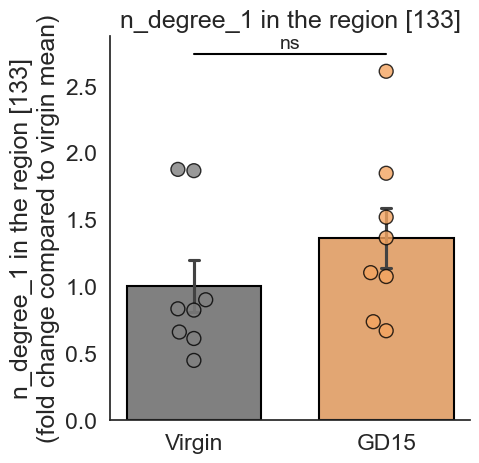

In [35]:
order = ['Virgin', 'GD15'] # in which order organize the bars
colors = ['grey', 'sandybrown'] # colors of the bars 

sns.set(font_scale=1.5)
sns.set_style(style='white')

fig = sns.catplot(x='group', y=STATS, 
            order=order,
            kind="bar", 
            errorbar='se',
            data=grouped_df, 
            width=0.7,
            palette=colors,
            hue='group',
            linewidth=1.5, 
            edgecolor='black',
            ecolor='black',
            capsize=0.05,
            legend=None
            )

ax = sns.swarmplot(x='group', y=STATS, 
                   order=order, 
                   data=grouped_df, 
                   palette=colors,
                   hue='group',
                   size=10, 
                   linewidth=1, 
                   edgecolor='black', 
                   alpha=0.8, 
                   dodge=False,
                   legend=False)

# Significance levels 
ax = fig.ax
x1, x2 = 0, 1
y = grouped_df[STATS].max() * 1.05
ax.plot([x1, x2], [y, y], color='black', linewidth=1.5)
ax.text((x1 + x2) / 2, y * 1.005, result_t_test, 
        ha='center', va='bottom', fontsize=14)


plt.title(f'{STATS} in the region {REGION}')
plt.ylabel(f"{STATS} in the region {REGION}" + '\n' + "(fold change compared to virgin mean)")
plt.xlabel("")
plt.xticks(range(len(colors)))
fig.set_xticklabels(order)
# fig.set(ylim=(0.8, 1.5))

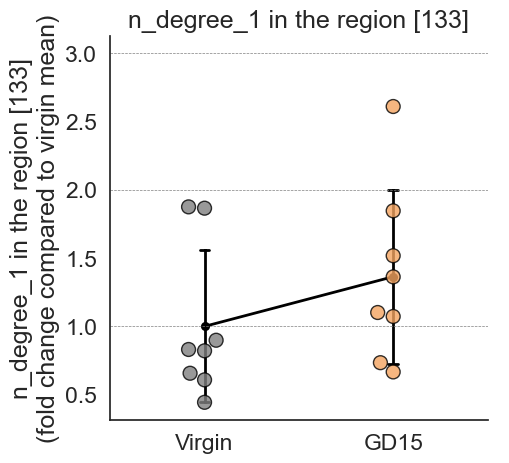

In [19]:
order = ['Virgin', 'GD15'] # in which order organize the bars
colors = ['grey', 'sandybrown'] # colors of the bars 

sns.set(font_scale=1.5)
sns.set_style(style='white')

fig = sns.catplot(x='group', y=STATS, 
            order=order,
            kind="point", 
            # hue='group',
            errorbar='sd',
            data=grouped_df, 
            capsize=0.05,
            color='black',
            linewidth=2
            )

ax = sns.swarmplot(x='group', y=STATS, 
                   order=order, 
                   data=grouped_df, 
                   palette=colors,
                   hue='group',
                   size=10, 
                   linewidth=1, 
                   edgecolor='black', 
                   alpha=0.8, 
                   dodge=False,
                   legend=False)

for i in [1,2,3]:
    plt.axhline(y = i, color = 'grey', linestyle = '--',linewidth=0.5) 

plt.title(f'{STATS} in the region {REGION}')
plt.ylabel(f"{STATS} in the region {REGION}" + '\n' + "(fold change compared to virgin mean)")
plt.xlabel("")
plt.xticks(range(len(colors)))
fig.set_xticklabels(order)
# fig.set(ylim=(0.8, 1.5))